<a href="https://colab.research.google.com/github/wellBorges/PUC_PLN/blob/main/u4_03_hands_on_1_analise_de_sentimentos_pratica_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Sentimentos
A extração de sentimentos do consumidor, do usuário, do eleitor ou do público em geral a partir de textos recebidos.


In [1]:
# Instalação dos pacotes necessários
!pip install nltk==3.8.1 \
  scikit-learn==1.2.2 \
  vaderSentiment==3.3.2 \
  wordcloud==1.9.3 \
  unidecode==1.3.8 \
  seaborn==0.13.1 \
  textblob==0.17.1 \
  pandas==2.0.3 \
  transformers==4.38.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.2
    Uninstalling transformers-4.41.2:
      Successfully uninstalled transformers-4.41.2


In [2]:
# Importações da biblioteca padrão
import datetime
import math
import pickle
import re
import string
import sys
import warnings

# Importações de bibliotecas de terceiros
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob
import transformers
from unidecode import unidecode
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

# Downloads do NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Configurações e comandos específicos (por exemplo, desativar avisos)
warnings.filterwarnings('ignore')

print("Pacotes importados com sucesso! Notebook pronto para uso.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Pacotes importados com sucesso! Notebook pronto para uso.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Declara define funções utilitárias utilizadas no notebook.
def formata_msg(nivel, msg):
    """
    Formata uma mensagem de log incluindo o nível de severidade, timestamp
    e a mensagem.

    Parâmetros:
    - nivel (str): Nível de severidade da mensagem (ex: 'INFO', 'ERROR', 'WARNING').
    - msg (str): A mensagem de log propriamente dita.

    Retorna:
    - str: A mensagem de log formatada.
    """
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    return f"[{nivel}] {timestamp} - {msg}"

def preprocessa_texto(texto):
    """
    Preprocessa o texto fornecido realizando várias etapas de limpeza.

    Etapas:
    1. Tokeniza o texto.
    2. Converte os tokens para minúsculos.
    3. Remove stopwords em português.
    4. Remove números dos tokens.
    5. Exclui tokens que são pontuações.
    6. Remove acentuações dos tokens.

    Parâmetros:
    texto (str): O texto a ser preprocessado.

    Retorna:
    list: Lista de tokens preprocessados.
    """

    padrao = r"\w+(?:'\w+)?|[^\w\s]"

    tokens_preprocessados = re.findall(padrao, texto)
    tokens_preprocessados = [token.lower() for token in tokens_preprocessados]
    tokens_preprocessados = [token for token in tokens_preprocessados if token not in stopwords.words('english')]
    tokens_preprocessados = [re.sub(r'\d+', '', token) for token in tokens_preprocessados if re.sub(r'\d+', '', token)]
    tokens_preprocessados = [token for token in tokens_preprocessados if token not in string.punctuation]
    tokens_preprocessados = [unidecode(token) for token in tokens_preprocessados]

    return ' '.join(tokens_preprocessados)

print(formata_msg("INFO", "Funções utilitárias prontas para utilização."))
print(formata_msg("INFO", f"Versão do Python: {sys.version} "))

[INFO] 2024-06-19 16:53:07 - Funções utilitárias prontas para utilização.
[INFO] 2024-06-19 16:53:07 - Versão do Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] 


In [4]:
# URL para download dos dados de treinamento.
url = (
    "https://raw.githubusercontent.com/gomesluiz/"
    "pln-na-pratica/main/datasets/financial_sentiment.csv"
)
sentimentos = pd.read_csv(url)
sentimentos.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


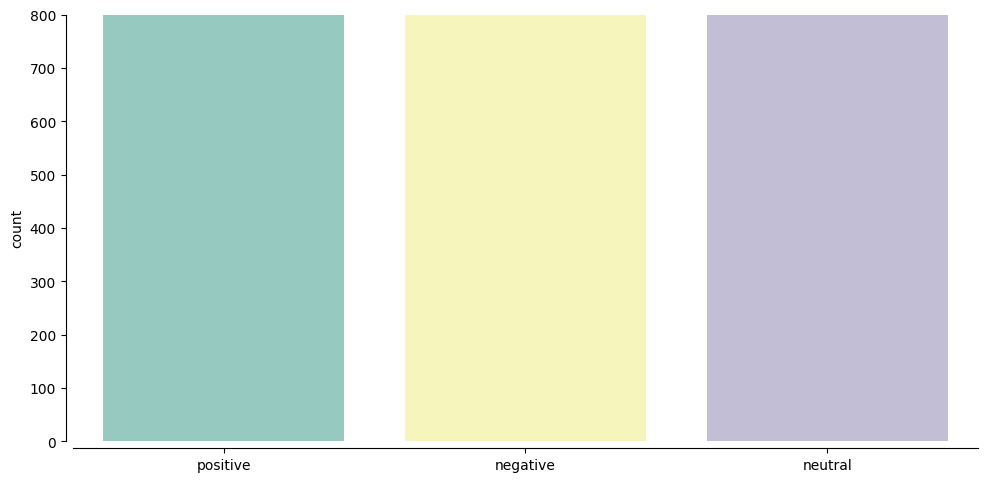

In [5]:
g = sns.catplot(data=sentimentos
                , x="Sentiment"
                , height=5
                , aspect=2
                , kind="count"
                , palette="Set3"
                , hue="Sentiment"
                , legend=False)
sns.despine(offset=5)

g.set(ylim=(0, 800))
g.set(xlabel=None)


# Aprendizado de Máquina

In [6]:
# Pré-processa a coluna de sentenças.
sentimentos["Preprocessed_Sentence"] = sentimentos["Sentence"].apply(preprocessa_texto)
sentimentos.head()

,Sentence,Sentiment,Preprocessed_Sentence
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi lows bk real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter componenta net sales doubled eurm...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnish russian chamber commerce maj...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining percent sta...


In [7]:
# Divide o dataset de trechos de textos em treinamento e teste.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentimentos["Preprocessed_Sentence"], sentimentos["Sentiment"], test_size=.25, random_state=32)

In [8]:
# Vetoriza os conjuntos de treinamento.
vetorizador = CountVectorizer(max_features=1000)
X_train_vetorizado = vetorizador.fit_transform(X_train)
X_train_vetorizado = pd.DataFrame(X_train_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_train_vetorizado.index = X_train_vetorizado.index
X_train_vetorizado.head()

,aapl,ab,able,access,accordance,according,accounting,acquire,acquired,acquisition,...,worth,would,www,xac,year,years,yesterday,yet,yhoo,yit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Vetoriza os conjuntos de testes.
X_test_vetorizado = vetorizador.transform(X_test)
X_test_vetorizado = pd.DataFrame(X_test_vetorizado.toarray(), columns=vetorizador.get_feature_names_out())
X_test_vetorizado.index = X_test_vetorizado.index
X_test_vetorizado.head()

,aapl,ab,able,access,accordance,according,accounting,acquire,acquired,acquisition,...,worth,would,www,xac,year,years,yesterday,yet,yhoo,yit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [10]:
# Treina o modelo de classificação de sentimentos.
clf = MultinomialNB()
_ = clf.fit(X_train_vetorizado, y_train)
print(formata_msg("INFO", "Modelo base treinado"))

[INFO] 2024-06-19 16:55:28 - Modelo base treinado


In [11]:
y_pred = clf.predict(X_test_vetorizado)
print(formata_msg("INFO", "Modelo base testado"))

[INFO] 2024-06-19 16:55:37 - Modelo base testado


In [12]:
# Calcula a acurácia do modelo.
acc = accuracy_score(y_pred, y_test)
print(formata_msg("INFO", f"Acurácia: {acc}"))

[INFO] 2024-06-19 16:55:42 - Acurácia: 0.6687200547570158


## Text Blob
[TextBlob](https://textblob.readthedocs.io/en/dev/) é uma biblioteca Python para o processamento de dados textuais. Ela fornece uma API simples para tarefas comuns de PLN, como análise de sentimentos.

In [13]:
# Determina a polaridade do texto
texto_1 = sentimentos.iloc[0]["Sentence"]
texto_2 = sentimentos.iloc[1]["Sentence"]
texto_3 = sentimentos.iloc[3]["Sentence"]

p_1 = TextBlob(texto_1).sentiment.polarity
p_2 = TextBlob(texto_2).sentiment.polarity
p_3 = TextBlob(texto_3).sentiment.polarity
print(formata_msg("INFO",f"\n{p_1}\n{p_2}\n{p_3}"))

[INFO] 2024-06-19 16:55:52 - 
0.2090909090909091
0.022222222222222213
0.0625


## VADER
[VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner) é uma ferramenta de análise de sentimentos baseada em léxico e regras, que é especificamente ajustada para sentimentos expressos em mídias sociais.


In [14]:
sentiment = SentimentIntensityAnalyzer()
se_1 = sentiment.polarity_scores(texto_1)
se_2 = sentiment.polarity_scores(texto_2)
se_3 = sentiment.polarity_scores(texto_3)
print(formata_msg("INFO",f"\n{se_1}\n{se_2}\n{se_3}"))

[INFO] 2024-06-19 16:56:29 - 
{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.5423}
{'neg': 0.153, 'neu': 0.847, 'pos': 0.0, 'compound': -0.2023}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


## Transformers
[Transformers](https://github.com/huggingface/transformers) oferece milhares de modelos pré-treinados para realizar tarefas em diferentes modalidades, como texto, visão e áudio.

In [16]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
textos = [texto_1, texto_2, texto_3]
se = sentiment_pipeline(textos)
print(formata_msg("INFO",f"\n{se}"))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[INFO] 2024-06-19 16:57:08 - 
[{'label': 'POSITIVE', 'score': 0.9991747736930847}, {'label': 'NEGATIVE', 'score': 0.9931260347366333}, {'label': 'POSITIVE', 'score': 0.9968819618225098}]
